# Protein Sequence Classification on pfam dataset

## 1. Business Problem

### 1.1 Description

[Proteins](https://en.wikipedia.org/wiki/Protein) are large, complex biomolecules that play many critical roles in biological bodies. Proteins are made up of one or more long chains of [amino acids](https://en.wikipedia.org/wiki/Amino_acid) sequences. These Sequence are the arrangement of amino acids in a protein held together by [peptide bonds](https://en.wikipedia.org/wiki/Peptide_bond). Proteins can be made from [20](https://www.hornetjuice.com/amino-acids-types/) different kinds of amino acids, and the structure and function of each protein are determined by the kinds of amino acids used to make it and how they are arranged. 

Understanding this relationship between amino acid sequence and protein function is a long-standing problem in moleculer biology with far-reaching scientific implications. Can we use deep learning that learns the relationship between unaligned amino acid sequences and their functional annotations across all 17929 families of the Pfam database.

[Pfam](https://en.m.wikipedia.org/wiki/Pfam) is a database of [protein families](https://en.m.wikipedia.org/wiki/Protein_family) that includes their annotations and multiple sequence alignments.

__Problem Statement__
- Classification of protein's amino acid sequence to one of the protein family accession, based on PFam dataset.
- In other words, the task is: given the amino acid sequence of the protein domain, predict which class it belongs to.


### 1.2 Sources/Useful Links

- Source: [Pfam seed random split](https://www.kaggle.com/googleai/pfam-seed-random-split)
- Paper: [Using deep learning to annotate the protein universe](https://www.biorxiv.org/content/10.1101/626507v4.full).

### 1.3 Real world/Business Objectives and Constraints

Objectives
- Predict protein family accession from its amino acids sequence with high accuracy.

Constraints
- No strict latency concerns.

## 2. Machine Learning Problem

### 2.1 Data

#### 2.1.1 Data Overview

- `sequence`: These are usually the input features to the model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.

- `family_accession`: These are usually the labels for the model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

- `sequence_name`: Sequence name, in the form "uniprot_accession_id/start_index-end_index". 

- `aligned_sequence`: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

- `family_id`: One word name for family. 

#### 2.1.2 Example Data point



```
sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
```



#### 2.1.3 Data split

- We have been provided with already done random split(train, val, test) of pfam dataset.
  - Train - 80% (For training the models).
  - Val - 10% (For hyperparameter tuning/model validation).
  - Test - 10% (For acessing the model performance).

### 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine learning Problem

It is a multi class classification problem, for a given sequence of amino acids we need to predict its family accession.

#### 2.2.2 Performance Metric

- Multi class log loss
- Accuracy

## 3. Exploratory Data Analysis

### Importing Libraries

In [84]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
#from keras.utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional,  GlobalMaxPooling1D, LSTM
#from tensorflow.compat.v1.keras.layers import LSTM

In [85]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [86]:
#from google.colab import drive
#drive.mount('/content/drive')

### Loading Data

In [45]:
data_path = 'D:/googledownload/random_split/random_split'
print('Available data', os.listdir(data_path))

Available data ['dev', 'test', 'train']


In [46]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None))
    return pd.concat(data)

In [47]:
# reading all data_partitions

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

### Basic Statistics

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086741 entries, 0 to 13514
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   family_id         1086741 non-null  object
 1   sequence_name     1086741 non-null  object
 2   family_accession  1086741 non-null  object
 3   aligned_sequence  1086741 non-null  object
 4   sequence          1086741 non-null  object
dtypes: object(5)
memory usage: 49.7+ MB


In [49]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [50]:
# ex: unaligned sequence
# each character reperesents one of the 24(20 common + 4 uncommon) amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [51]:
# Given data size
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [52]:
def calc_unique_cls(train, test, val):
    """
    Prints # unique classes in data sets.
    """
    train_unq = np.unique(train['family_accession'].values)
    val_unq = np.unique(val['family_accession'].values)
    test_unq = np.unique(test['family_accession'].values)

    print('Number of unique classes in Train: ', len(train_unq))
    print('Number of unique classes in Val: ', len(val_unq))
    print('Number of unique classes in Test: ', len(test_unq))

In [53]:
# Unique classes in the given dataset : [df_train, df_val and df_test]

calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


### Sequence Counts

In [54]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [55]:
def plot_seq_count(df, data_name):
    sns.distplot(df['seq_char_count'].values)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

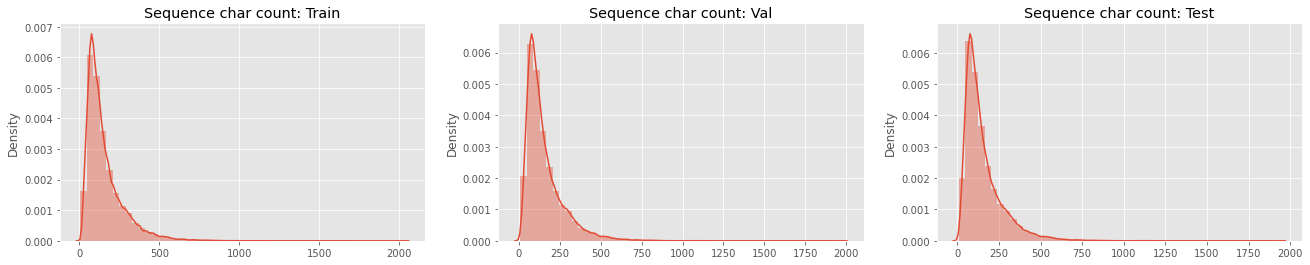

In [56]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observation__
- Most of the unaligned amino acid sequences have character counts in the range of 50-250.

### Sequence Code Frequency

Amino acid sequences are represented with their corresponding 1 letter code, for example, code for alanine is (A), arginine is (R) and so on. The complete list of amino acids with there code can be found <a href='http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html'>here</a>.

In [57]:
def get_code_freq(df, data_name):
  
    df = df.apply(lambda x: " ".join(x))
  
    codes = []
    for i in df: # concatination of all codes
        codes.extend(i)

    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space
  
    print(f'Codes: {data_name}')
    print(f'Total unique codes: {len(codes_dict.keys())}')

    df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
    return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [58]:
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 25


,Code,Freq
0,L,17062816
1,A,14384873
2,V,11913147
3,G,11845579
4,E,10859966
5,S,10597822
6,I,10234455
7,R,9406165
8,D,9371097
9,K,9127832


In [59]:
# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 22


,Code,Freq
0,L,1967025
1,A,1667703
2,V,1382128
3,G,1376124
4,E,1249356
5,S,1210750
6,I,1185722
7,R,1085950
8,D,1080572
9,K,1047638


In [60]:
# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 24


,Code,Freq
0,L,1967046
1,A,1668137
2,V,1380962
3,G,1375349
4,E,1251000
5,S,1210559
6,I,1184239
7,R,1085786
8,D,1078379
9,K,1045957


In [61]:
def plot_code_freq(df, data_name):
  
    plt.title(f'Code frequency: {data_name}')
    sns.barplot(x='Code', y='Freq', data=df)

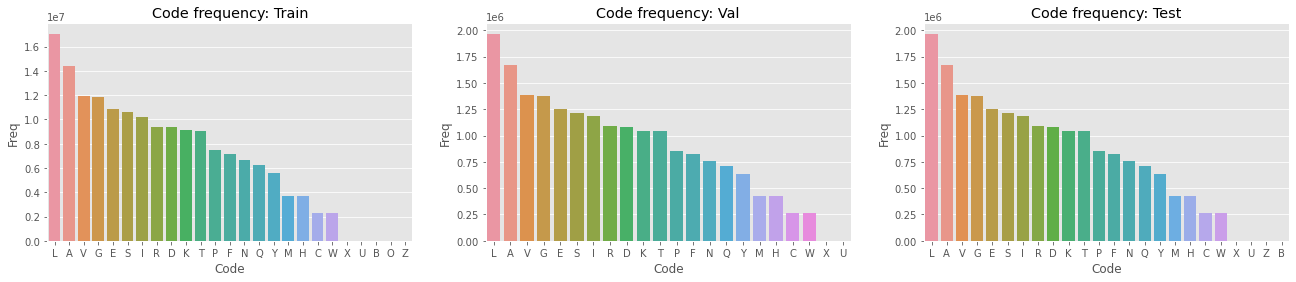

In [62]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__
- Most frequent amino acid code is L followed by A, V, G.
- As we can see, that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

### Protein families with most sequences(No. of observations)

In [63]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [64]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [65]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

__Observation__

- Top 20 classes are same across all the sets [train, test, val].
- Test and Val sets have almost same frequency for the top 20 classes.

### Considering 1000 classes based on no. of observations.

In [66]:
# Considering top 1000 classes based on most observations because of limited computational power.

classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

1000

In [67]:
# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 439493
Val size : 54378
Test size : 54378


In [68]:
# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  1000
Number of unique classes in Val:  1000
Number of unique classes in Test:  1000


## 4. Deep Learning Models

### Text Preprocessing

In [69]:
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1

    return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [70]:
def integer_encoding(data):
    """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
    """
  
    encode_list = []
    for row in data['sequence'].values:
        row_encode = []
        for code in row:
            row_encode.append(char_dict.get(code, 0))
        encode_list.append(np.array(row_encode))
  
    return encode_list

In [71]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

In [72]:
# padding sequences

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((439493, 100), (54378, 100), (54378, 100))

In [73]:
# One hot encoding of sequences

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((439493, 100, 21), (54378, 100, 21), (54378, 100, 21))

In [74]:
# del train_pad, val_pad, test_pad
# del train_encode, val_encode, test_encode

# gc.collect()

In [75]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((439493,), (54378,), (54378,))

In [76]:
print('Total classes: ', len(le.classes_))
# le.classes_

Total classes:  1000


In [77]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((439493, 1000), (54378, 1000), (54378, 1000))

In [93]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [79]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

    train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
    print('Train loss: ', train_score[0])
    print('Train accuracy: ', train_score[1])
    print('-'*70)

    val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
    print('Val loss: ', val_score[0])
    print('Val accuracy: ', val_score[1])
    print('-'*70)

    test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
    print('Test loss: ', test_score[0])
    print('Test accuracy: ', test_score[1])

### Model 1: Bidirectional LSTM

In [87]:

x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1000, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 128)          2688      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              129000    
Total params: 230,504
Trainable params: 230,504
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [89]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=50, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/50
1717/1717 [==============================] - 1290s 749ms/step - loss: 7.0651 - accuracy: 0.0355 - val_loss: 3.7590 - val_accuracy: 0.3081
Epoch 2/50
1717/1717 [==============================] - 1167s 680ms/step - loss: 3.3441 - accuracy: 0.3764 - val_loss: 2.0285 - val_accuracy: 0.6608
Epoch 3/50
1717/1717 [==============================] - 1168s 680ms/step - loss: 2.0447 - accuracy: 0.6362 - val_loss: 1.3857 - val_accuracy: 0.7875
Epoch 4/50
1717/1717 [==============================] - 1172s 683ms/step - loss: 1.5082 - accuracy: 0.7397 - val_loss: 1.0583 - val_accuracy: 0.8446
Epoch 5/50
1717/1717 [==============================] - 1172s 683ms/step - loss: 1.2253 - accuracy: 0.7919 - val_loss: 0.8790 - val_accuracy: 0.8756
Epoch 6/50
1717/1717 [==============================] - 1170s 681ms/step - loss: 1.0598 - accuracy: 0.8219 - val_loss: 0.7928 - val_accuracy: 0.8881
Epoch 7/50
1717/1717 [==============================] - 1206s 702ms/step - loss: 0.9497 - accuracy: 0.8415

In [92]:
# saving model weights.
model1.save_weights('D:/googledownload/random_split/model/')

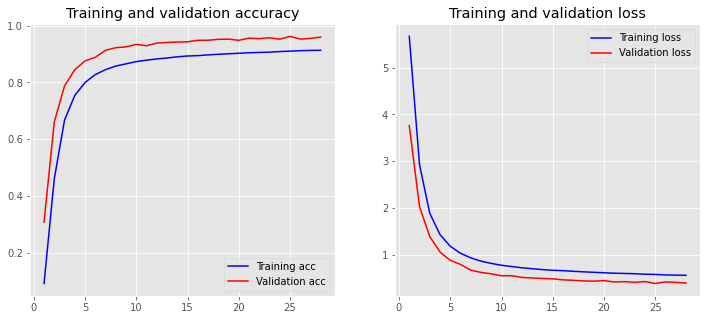

In [94]:
plot_history(history1)

In [95]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

1717/1717 [==============================] - 332s 193ms/step - loss: 0.3727 - accuracy: 0.9653
Train loss:  0.37269940972328186
Train accuracy:  0.9653031826019287
----------------------------------------------------------------------
213/213 [==============================] - 41s 190ms/step - loss: 0.3952 - accuracy: 0.9595
Val loss:  0.3951531946659088
Val accuracy:  0.9594689011573792
----------------------------------------------------------------------
213/213 [==============================] - 42s 196ms/step - loss: 0.3943 - accuracy: 0.9590 16s - loss: 0. - ETA: 11s - loss: 0.
Test loss:  0.39431002736091614
Test accuracy:  0.9590275287628174


### Model 2: ProtCNN (https://www.biorxiv.org/content/10.1101/626507v4.full)

<br/>
<center><img src='https://www.biorxiv.org/content/biorxiv/early/2019/07/15/626507/F6.large.jpg' height='470' width='700'></center>

<br/>

- One hot encoded unaligned sequence of amino acids is passed as the input to the network with zero padding.

- This network uses residual blocks inspired from [ResNet](https://arxiv.org/abs/1512.03385) architecture which also includes dilated convolutions offering larger receptive field without increasing number of model parameters.

In [97]:
def residual_block(data, filters, d_rate):
    """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
    """

    shortcut = data

    bn1 = BatchNormalization()(data)
    act1 = Activation('relu')(bn1)
    conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
    x = Add()([conv2, shortcut])

    return x

In [98]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 21)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 128)     2816        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 128)     0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [99]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [100]:
history2 = model2.fit(
    train_ohe, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

Epoch 1/10
1717/1717 [==============================] - 1192s 689ms/step - loss: 1.6804 - accuracy: 0.8260 - val_loss: 0.4629 - val_accuracy: 0.9839
Epoch 2/10
1717/1717 [==============================] - 1136s 662ms/step - loss: 0.4270 - accuracy: 0.9822 - val_loss: 0.4455 - val_accuracy: 0.9840
Epoch 3/10
1717/1717 [==============================] - 1120s 653ms/step - loss: 0.4159 - accuracy: 0.9838 - val_loss: 0.4392 - val_accuracy: 0.9856
Epoch 4/10
1717/1717 [==============================] - 971s 565ms/step - loss: 0.4081 - accuracy: 0.9849 - val_loss: 0.4353 - val_accuracy: 0.9850
Epoch 5/10
1717/1717 [==============================] - 692s 403ms/step - loss: 0.4000 - accuracy: 0.9858 - val_loss: 0.4242 - val_accuracy: 0.9853
Epoch 6/10
1717/1717 [==============================] - 699s 407ms/step - loss: 0.3962 - accuracy: 0.9854 - val_loss: 0.4233 - val_accuracy: 0.9866
Epoch 7/10
1717/1717 [==============================] - 689s 402ms/step - loss: 0.3865 - accuracy: 0.9866 - v

In [101]:
# saving model weights.
model2.save_weights('D:/googledownload/random_split/model2/')

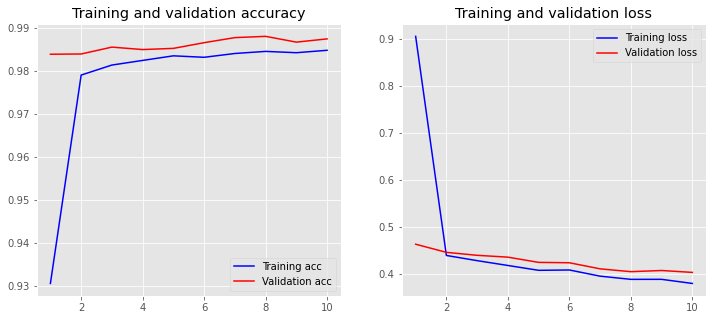

In [102]:
plot_history(history2)

In [103]:
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)

1717/1717 [==============================] - 181s 106ms/step - loss: 0.3605 - accuracy: 0.9962
Train loss:  0.3605440557003021
Train accuracy:  0.9962069988250732
----------------------------------------------------------------------
213/213 [==============================] - 22s 104ms/step - loss: 0.4028 - accuracy: 0.9875
Val loss:  0.4028223752975464
Val accuracy:  0.9874765276908875
----------------------------------------------------------------------
213/213 [==============================] - 24s 111ms/step - loss: 0.4050 - accuracy: 0.9870
Test loss:  0.40501630306243896
Test accuracy:  0.9870352149009705


## 5. Conclusion

In [104]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']

x.add_row(['1.', 'Bidirectional LSTM', '0.964', '0.957', '0.958'])
x.add_row(['2.', 'ProtCNN', '0.996', '0.988', '0.988'])

print(x)

+-------+--------------------+-----------+---------+----------+
| Sr.no |       Model        | Train Acc | Val Acc | Test Acc |
+-------+--------------------+-----------+---------+----------+
|   1.  | Bidirectional LSTM |   0.964   |  0.957  |  0.958   |
|   2.  |      ProtCNN       |   0.996   |  0.988  |  0.988   |
+-------+--------------------+-----------+---------+----------+


### Reference:

- https://www.biorxiv.org/content/10.1101/626507v4.full